# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# in powershell:
# !Invoke-WebRequest http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -OutFile ./data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# or in powershell
# !7z x .\pbmc3k_filtered_gene_bc_matrices.tar.gz | 7z x .\pbmc3k_filtered_gene_bc_matrices.tar
# !mkdir write

Also refer to the following resources for more information about Scanpy and single cell analysis in general:

- [Scanpy documentation homepage](https://scanpy.readthedocs.io/en/latest/index.html)
- [Scanpy tutorial homepage](https://scanpy.readthedocs.io/en/latest/tutorials.html)
- [Current best practices in single‐cell RNA‐seq analysis: a tutorial](https://www.embopress.org/doi/full/10.15252/msb.20188746)

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

## Loading libraries and setting the location path for analysis data

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

### Adjusting Scanpy default settings

Scanpy allows you to customize various aspects of the default package behavior. You can find the full list of options [here](https://scanpy.readthedocs.io/en/stable/api/index.html#settings).

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
#sc.settings.set_figure_params(dpi=80, facecolor='white')
# sc.settings.set_figure_params(dpi=80)
sc.settings.set_figure_params(dpi=80, fontsize=9, dpi_save=300, figsize=(4,3), format='png')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


In [3]:
results_file = './data/write/pbmc3k.h5ad'  # the file that will store the analysis results

## Reading in data

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [4]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache\data-filtered_gene_bc_matrices-hg19-matrix.h5ad


<div class="alert alert-info">

**Note**
    
See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.

</div>

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

You may want to read gene and cell data as DataFrame prior to `var_names_make_unique()`, to find genes with NaN values and filter the rows from the adata as follow:

```python
# reading in gene and cell data
gene_data = pd.read_csv(data_path + 'all_genes.csv')

# find genes with nan values and filter
gene_data = gene_data[gene_data.gene_name.notnull()]
notNa = gene_data.index
notNa = notNa.to_list()

# remove genes with nan values and assign gene names
adata = adata[:,notNa]
adata.var = gene_data
adata.var.set_index('gene_name', inplace=True)
adata.var.index.name = None
```

You may also want to add cell meta data to the anndata object:

```python
cell_meta = pd.read_csv(data_path + 'cell_metadata.csv')

adata.obs = cell_meta
adata.obs.set_index('bc_wells', inplace=True)
adata.obs.index.name = None
adata.obs_names_make_unique()
```

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing / Cell Quality Control

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


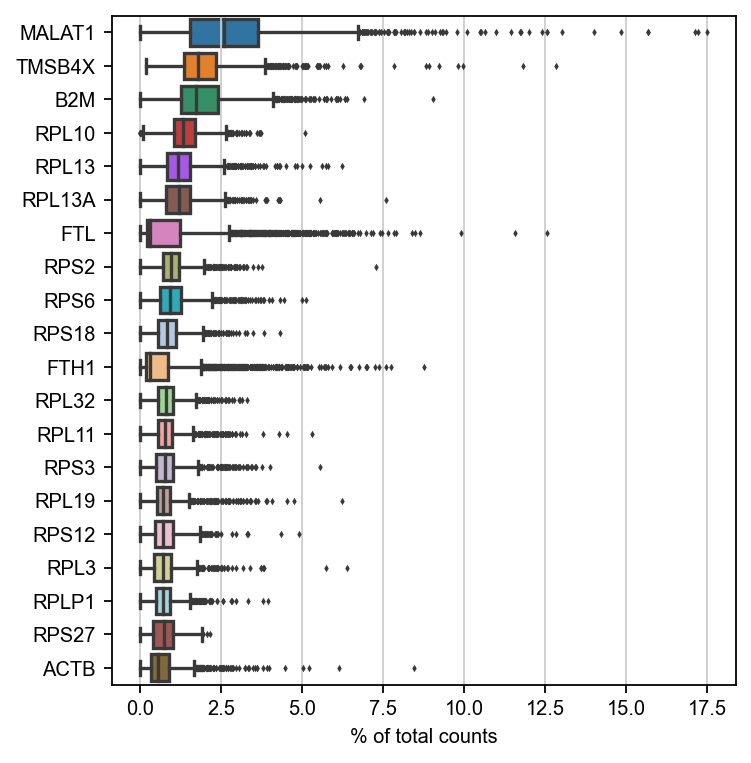

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Basic filtering

After reading in the data we'll perform basic filtering a on our expression matrix to remove low quality cells and uninformative genes. The parameter "min_genes" will keep cells that have at least 200 genes, and similarly, "min_cells" will keep genes that are expressed in at least 3 cells.

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In this step we'll perform cell quality control to prevent outlier cells from influencing downstream analyses. Cells that have unusually high transcript or gene counts are very likely to be multiplets, which is a term for two or more cells that have identical barcodes. Conversely, cells that have very low transcript or genes counts are a consequence of barcoding cells with damage membranes, or barcoding ambient RNA.

Filtering outliers can be accomplished by generating a violin plot for each cell feature and manually (or using quantile) selecting the threshold we wish to remove cells. We'll also add another important cell feature that shows the percentage of mitochondrial genes expressed in each cell. Cells with high mitochondrial gene percentages should be removed, as they are likely to have lost cytoplasmic RNA from lysis or may have increased apoptosis (Luecken and Theis 2019).

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently, including variables we want to control for, e.g., `pc_counts_mt`.

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

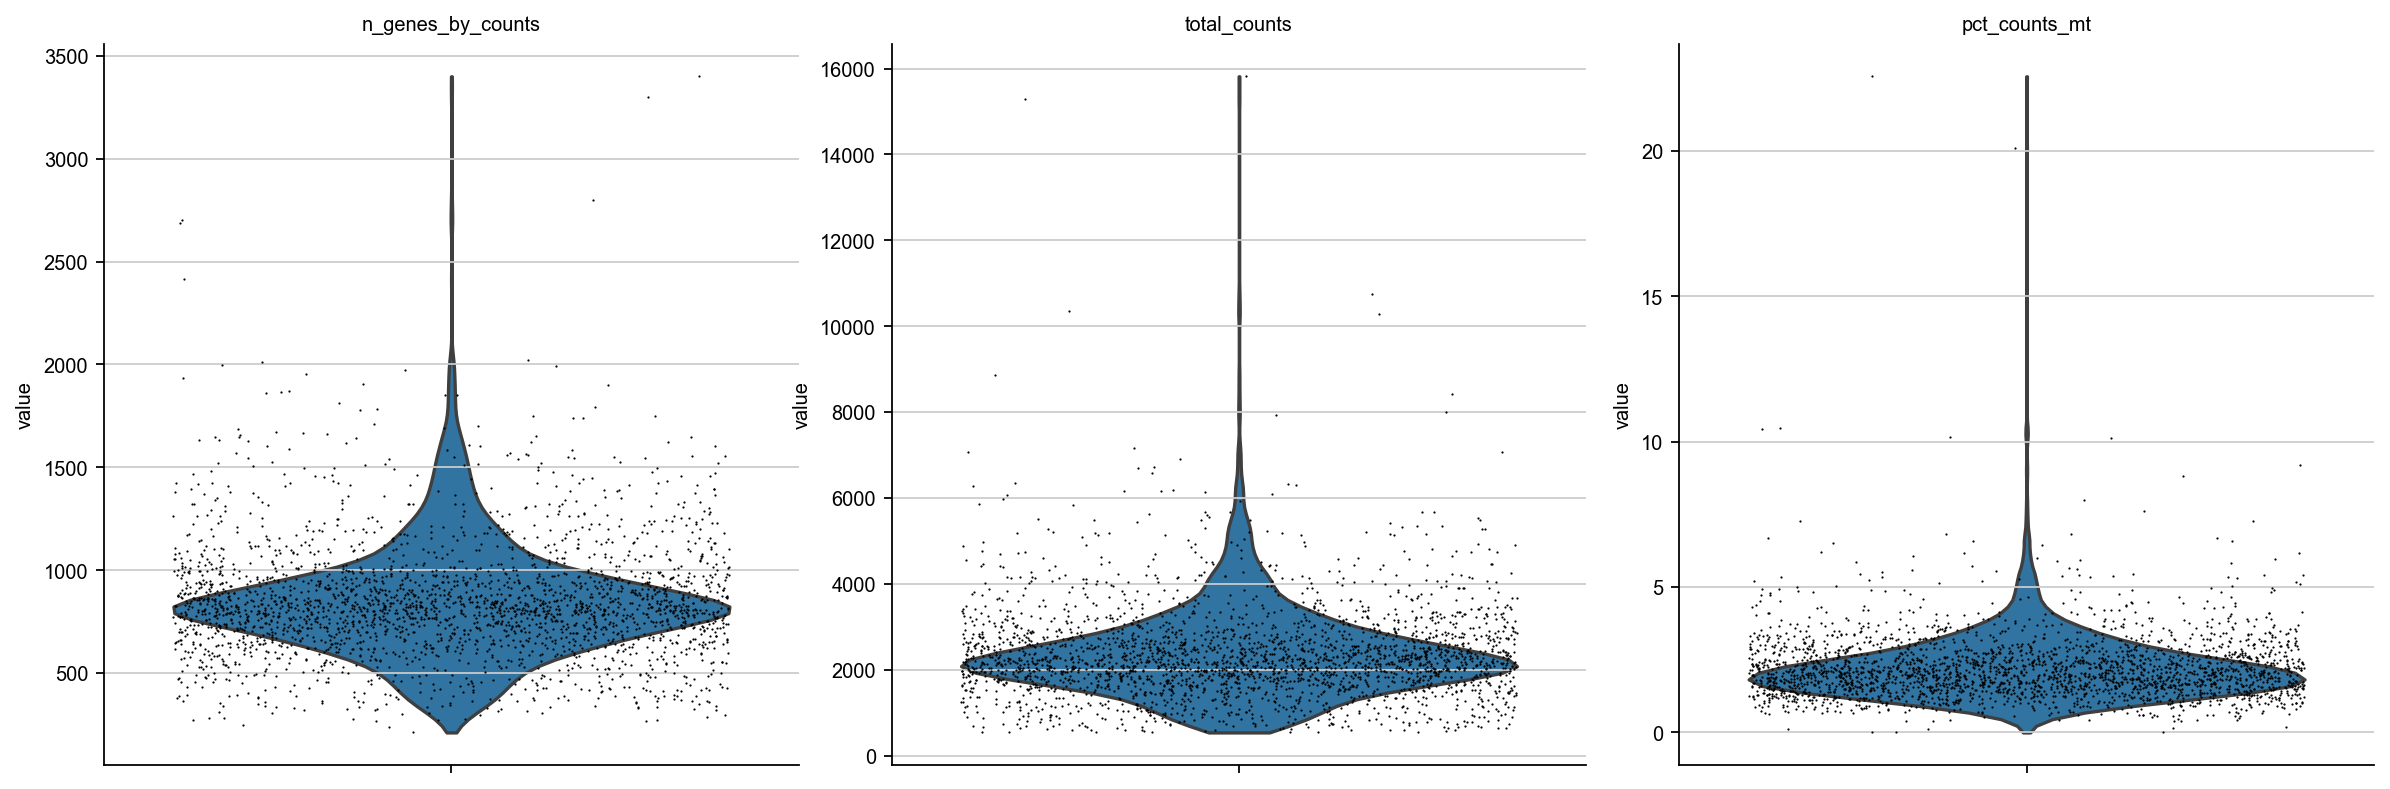

In [10]:
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True,
)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

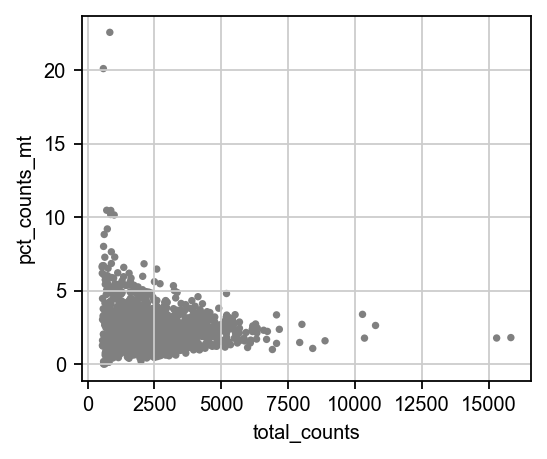

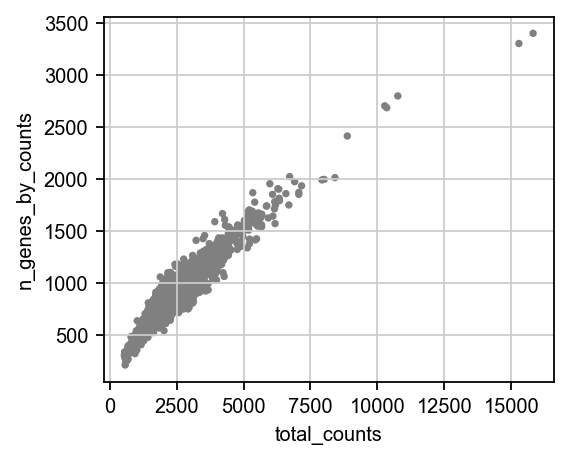

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Filtering the data

Actually do the filtering by slicing the `AnnData` object.

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.total_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [13]:
adata.shape # checking the number of cells and genes remaining

(2574, 13714)

In [14]:
adata

View of AnnData object with n_obs × n_vars = 2574 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Lets visualize the results of our filtered data and print the updated median transcript and gene counts.

In [15]:
print('median gene counts per cell: ' + str(adata.obs['total_counts'].median(0)))

median gene counts per cell: 2190.5


### Normalization

Now that we've removed the outlier cells, we can normalize the matrix to 10,000 reads per cell and log transform the results.

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize (1+n) the data:

In [17]:
sc.pp.log1p(adata) # returns the natural logarithm of 1 + the input array

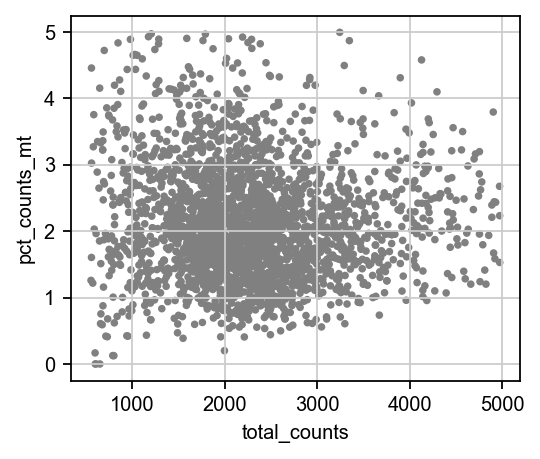

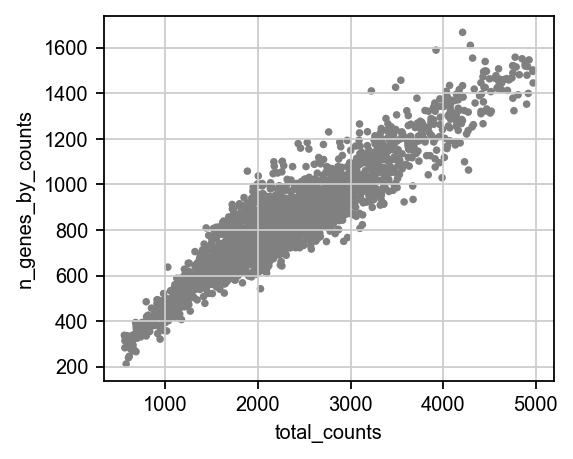

In [18]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Identify highly-variable genes and regress out transcript counts

Our next goal is to identify genes with the greatest amount of variance (i.e. genes that are likely to be the most informative). This subset of genes will be used to calculate a set of principal components which will determine how our cells are classified using Leiden clustering and UMAP. You can fine tune variable gene selection by adjusting the min/max mean expression and min/max dispersion.

The regress out function is used to correct for biases in cell attributes, such as the number transcripts per cell. It's important to note that this step can merge cell populations with subtle differences in gene expression, which may or may not align with your analysis goals. You can always start a separate analysis without this feature to see which model suits your objectives.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


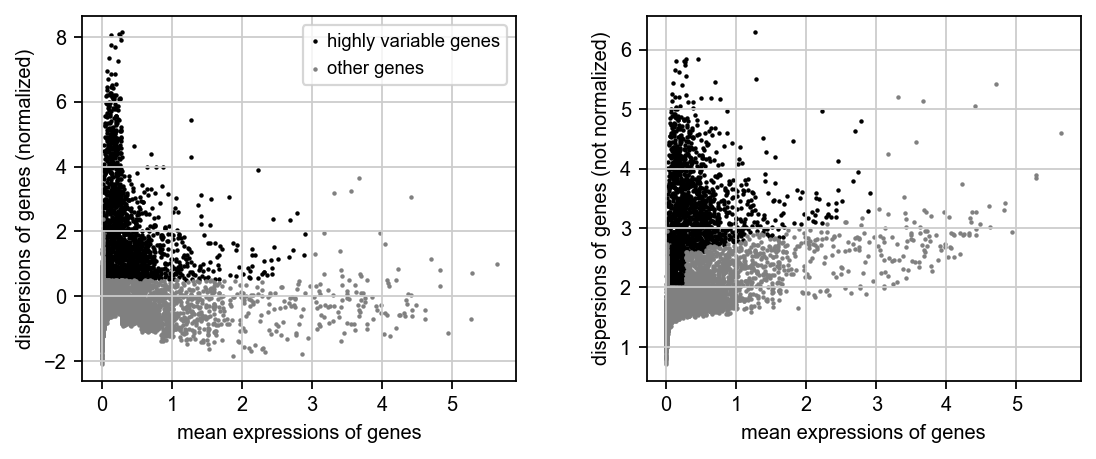

In [20]:
sc.pl.highly_variable_genes(adata, save='') # scanpy generates the filename automatically)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [21]:
# Save raw expression values before variable gene subset
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [22]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [23]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [24]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Now that we've extracted the most "informative" cells and genes from our dataset, we can start the process of dimensional reduction by generating a list of principal components (PCs). Principal component analysis will reduce the number of columns (variable gene expression values) to set of PCs which explain the variance in our dataset. Here we're using a simple and effective method for choosing the PCs by plotting the variance ratio for each PC and choosing the last PC where the ratio starts to "flatten" out. For this particular dataset we've chosen 30 PCs, which will be passed to the "sc.pp.neighbors" function in the next step.

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [25]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

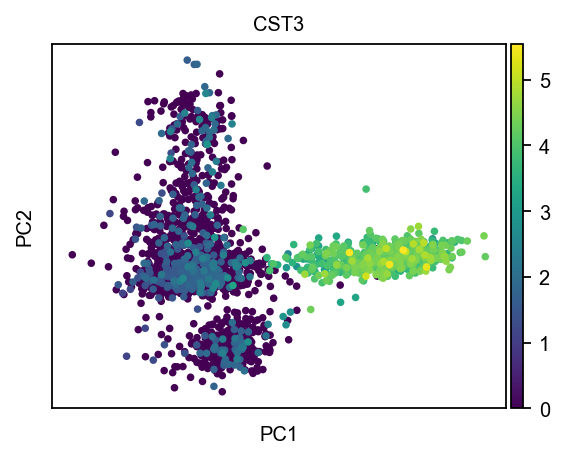

In [26]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

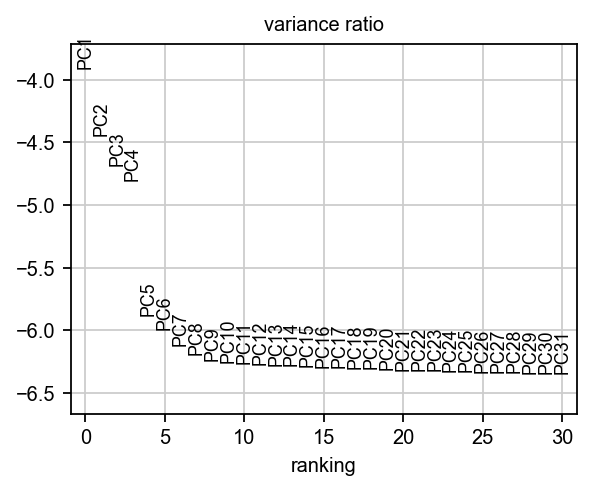

In [27]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [28]:
adata.write(results_file)

In [29]:
adata

AnnData object with n_obs × n_vars = 2574 × 1809
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## UMAP and Leiden Clustering

This step will involve reducing the dimensionality of our data into two dimensions using uniform manifold approximation (UMAP), allowing us to visualize our cell populations as they are binned into discrete populations using Leiden clustering. The "n_neighbors" parameter in the "sc.pp.neighbors" function will determine the size of each cell cluster; lower values will translate to a greater number of clusters by breaking up the dataset into smaller communities, and visa versa for larger values. We can also fine tune the number of clusters using the resolution parameter in the "sc.tl.leiden" function.

### Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [30]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


### Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [31]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


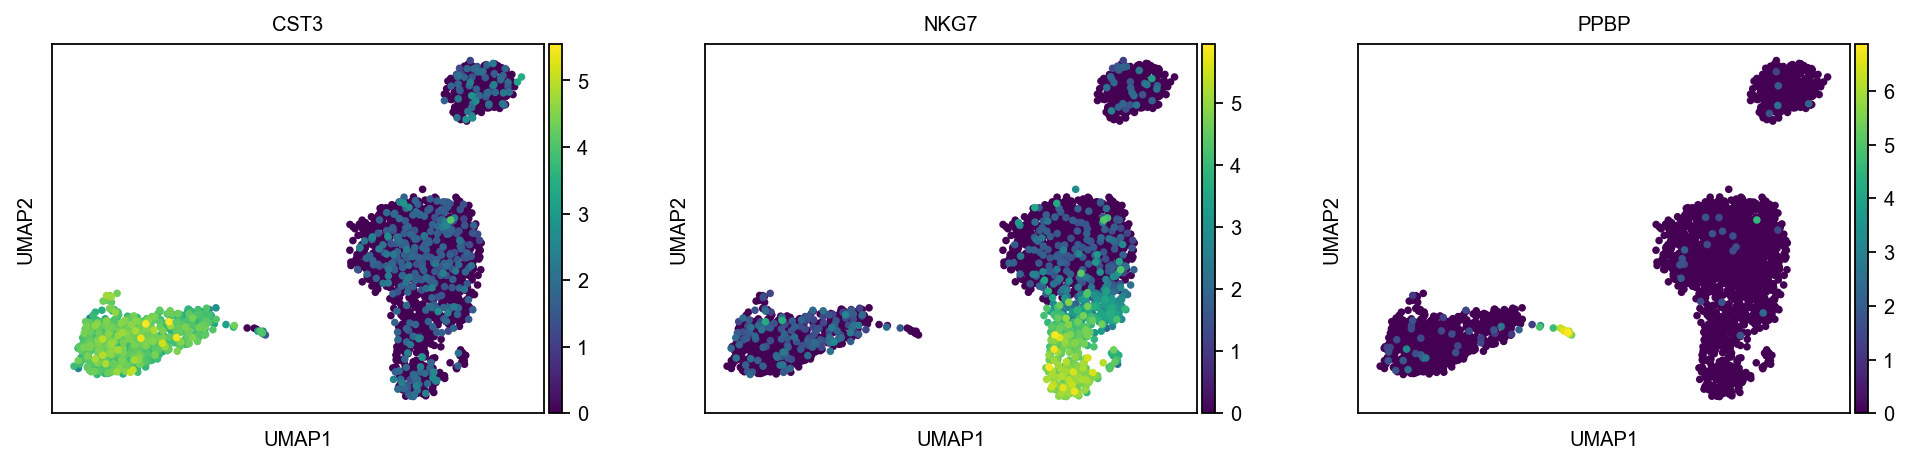

In [32]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

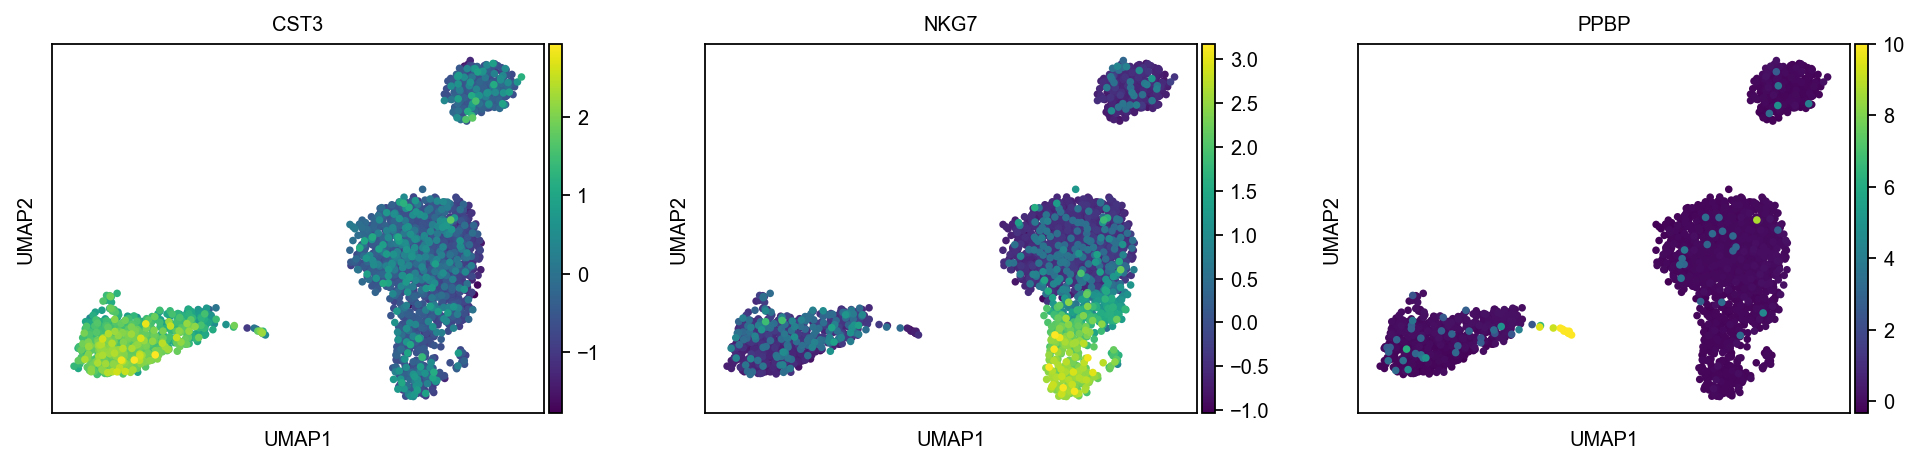

In [33]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

### Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [34]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


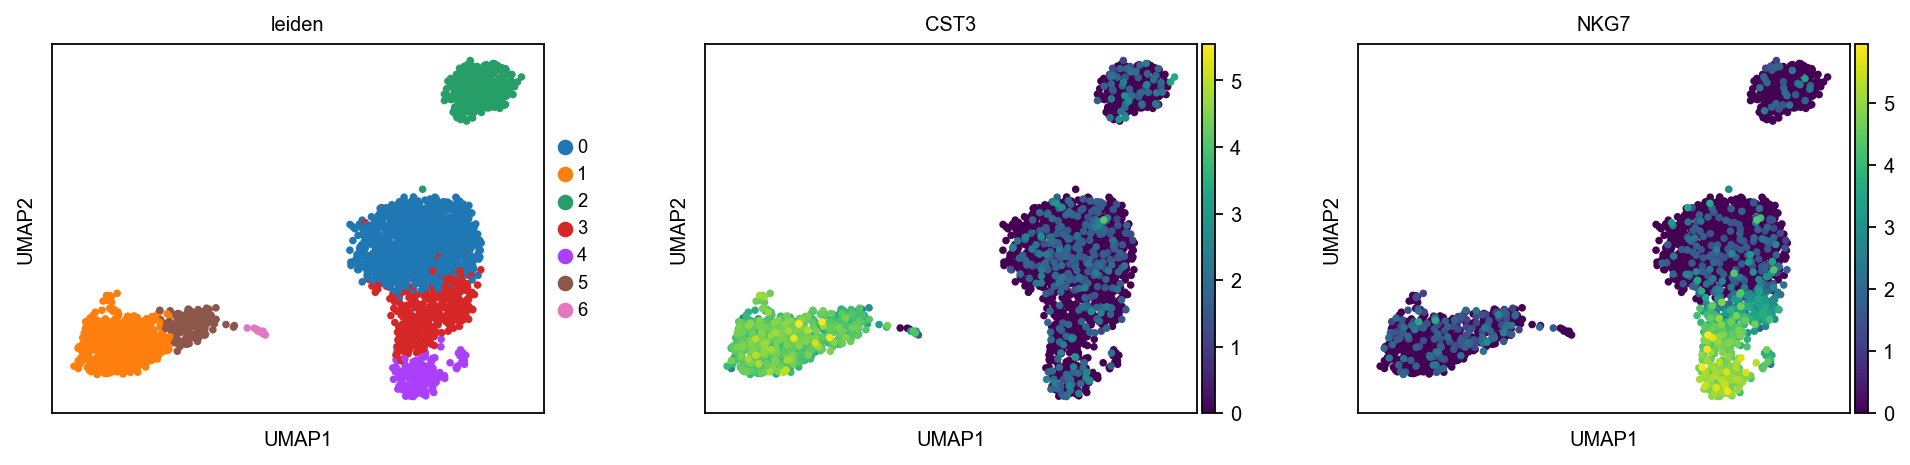

In [35]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the result.

In [36]:
adata.write(results_file)

## Finding marker genes

After determining the appropriate number clusters, we'll perform a statistical test to find genes enriched in each cell population. For this example we'll use the simplest and quickest method, the t-test. Scanpy provides a number of different statistical tests which can be found here.

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


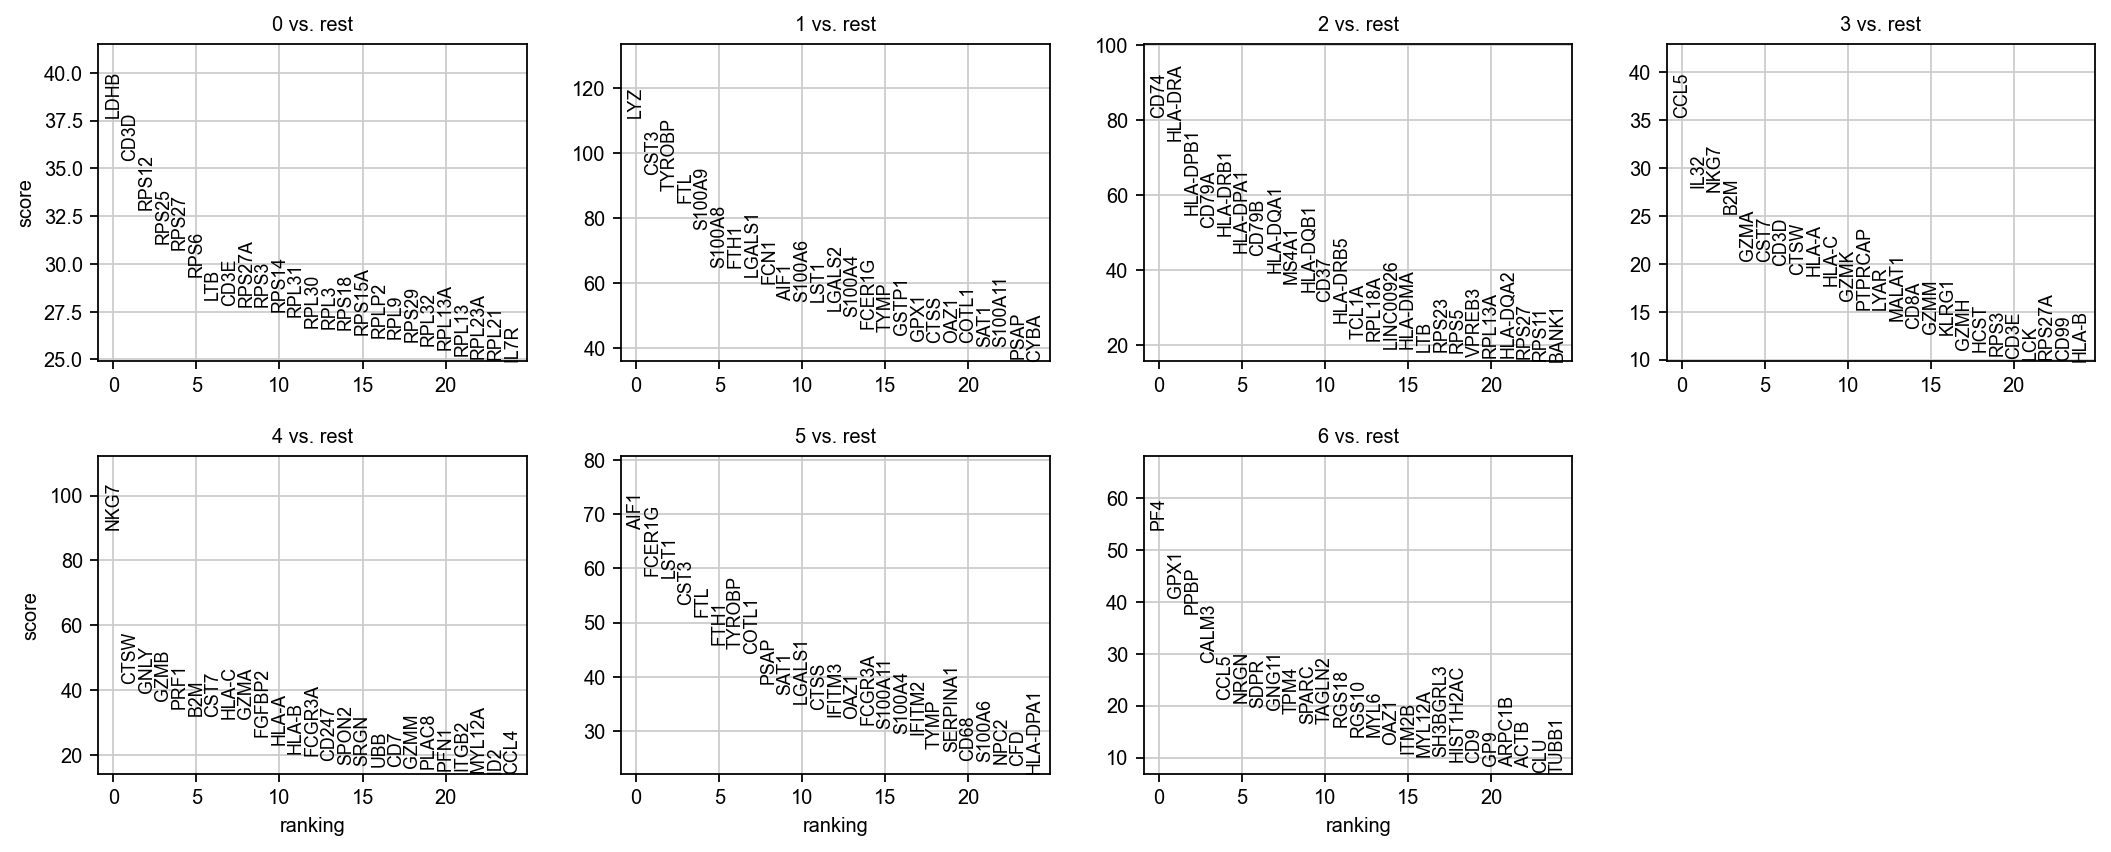

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:03)


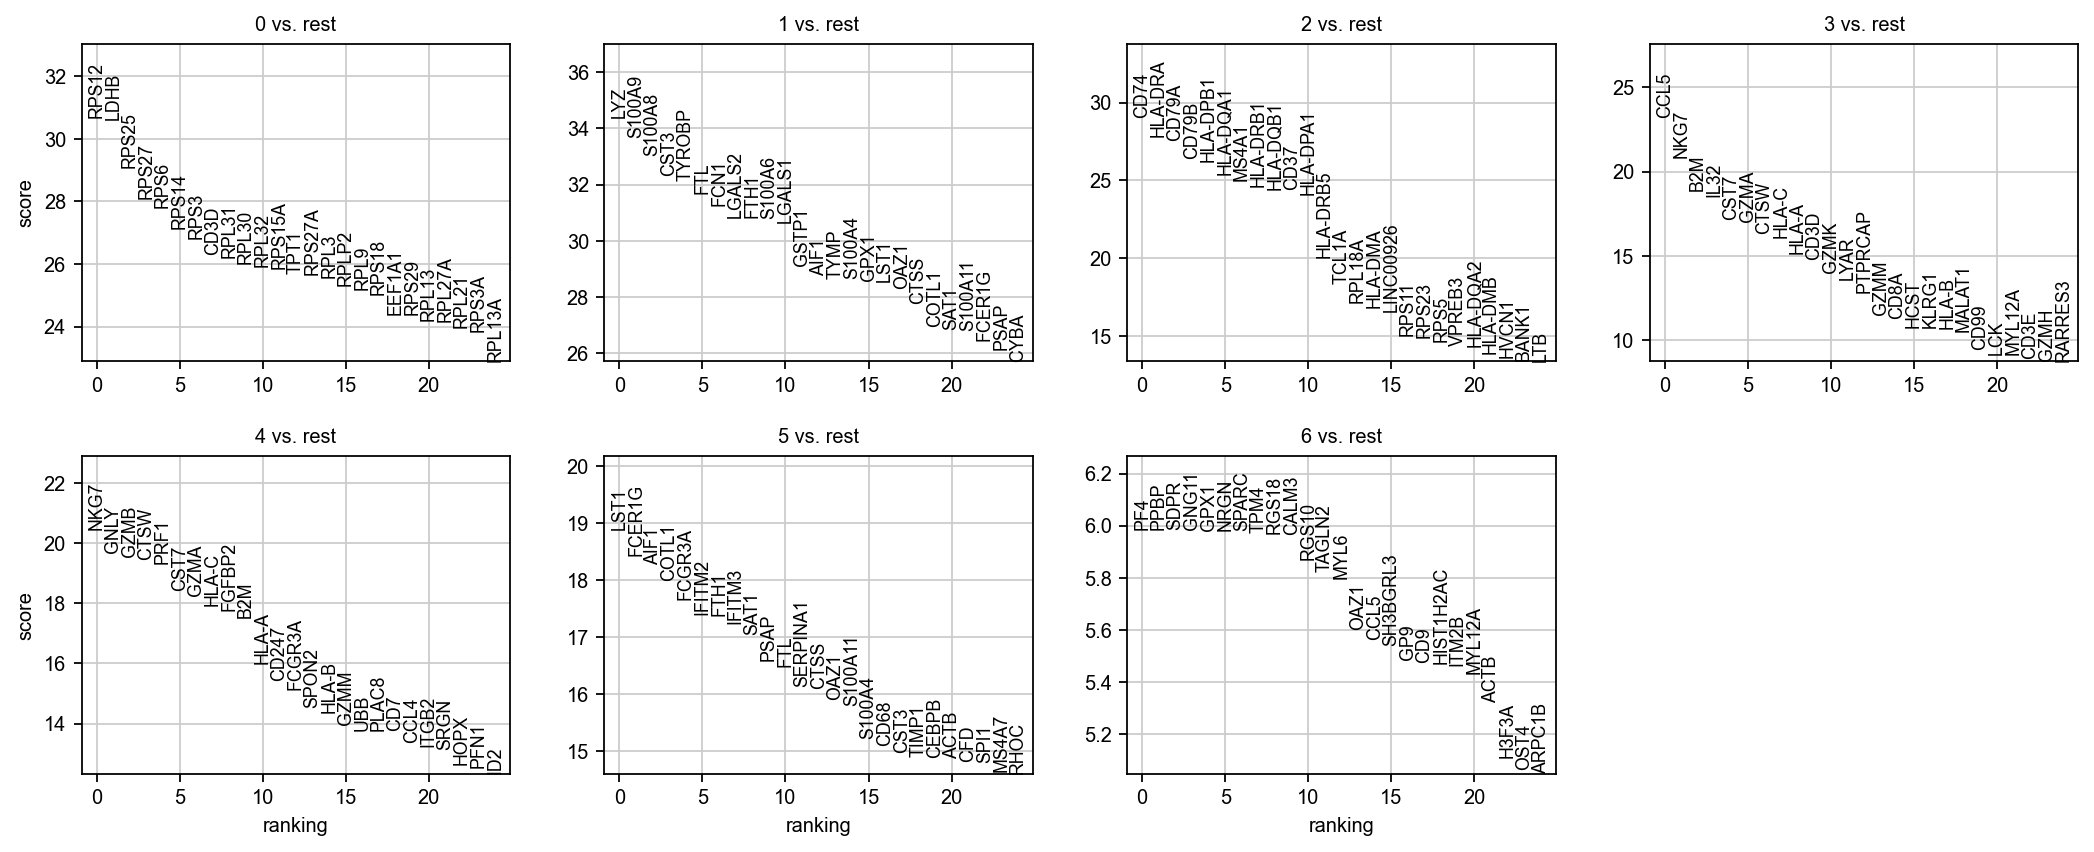

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [40]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:03)


c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


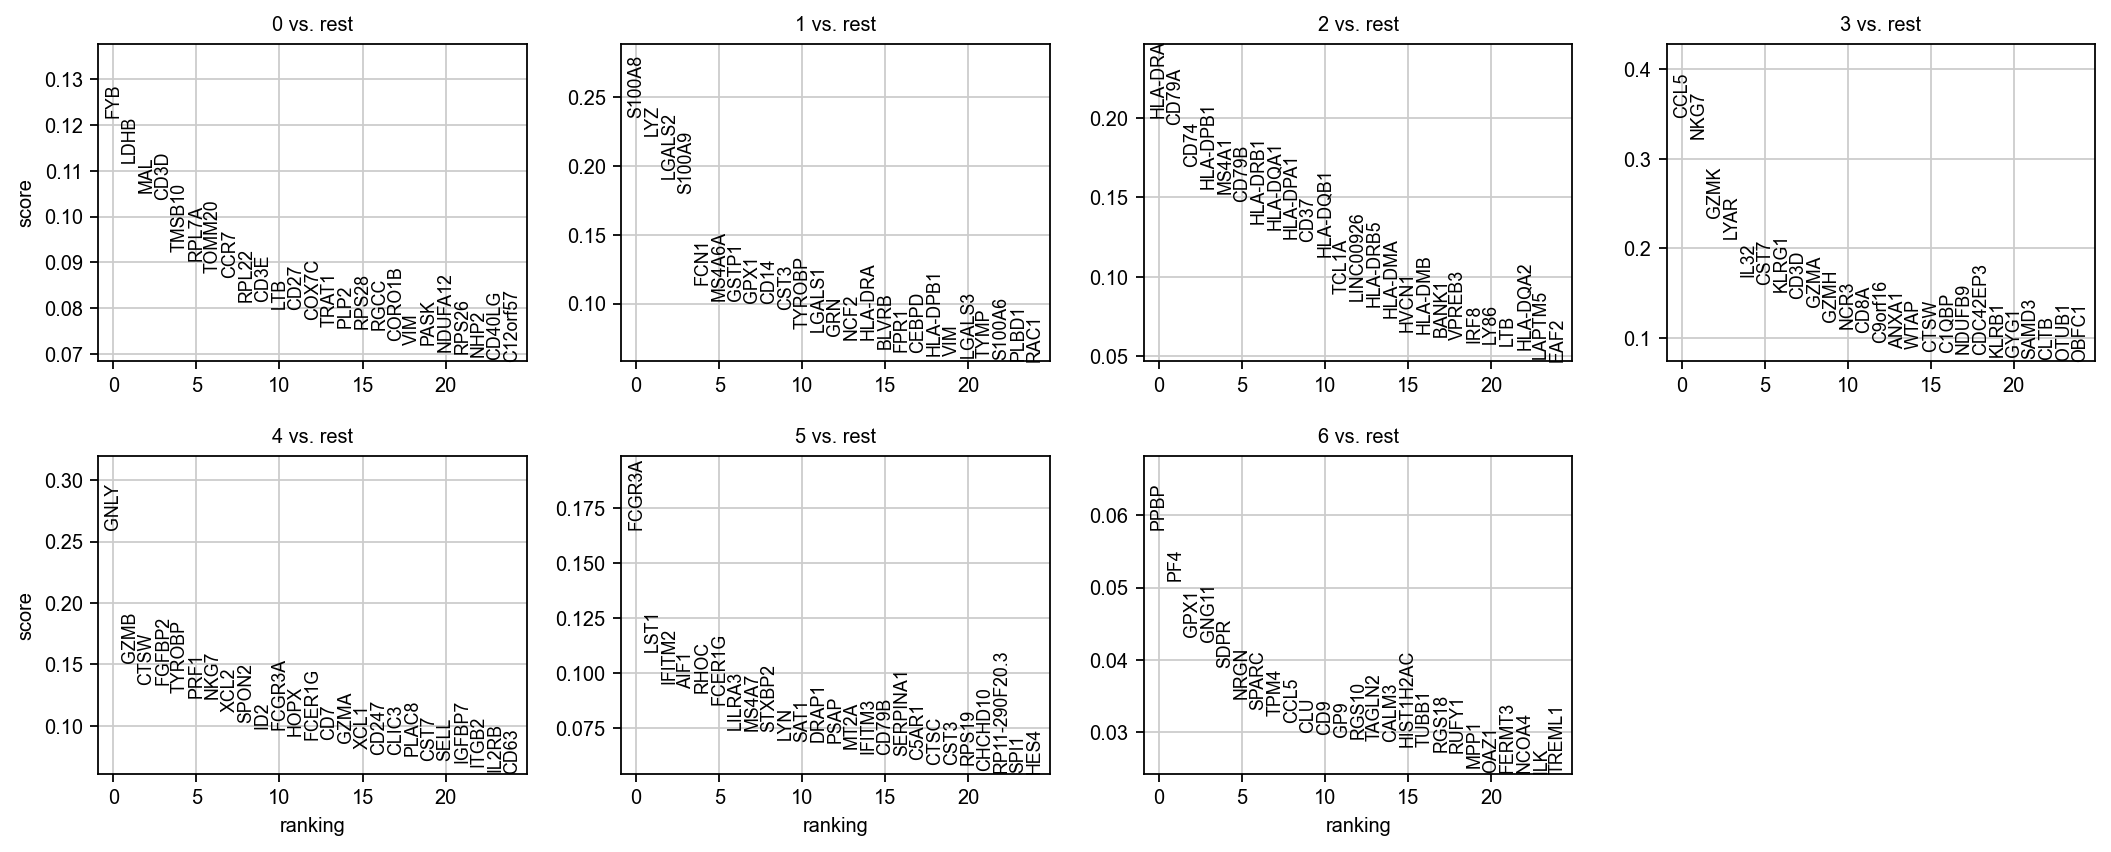

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
#Show the 10 top ranked genes per cluster 0, 1, ..., 6 in a dataframe.
top_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print(top_markers)

        0       1         2      3       4       5      6
0     FYB  S100A8   HLA-DRA   CCL5    GNLY  FCGR3A   PPBP
1    LDHB     LYZ     CD79A   NKG7    GZMB    LST1    PF4
2     MAL  LGALS2      CD74   GZMK    CTSW  IFITM2   GPX1
3    CD3D  S100A9  HLA-DPB1   LYAR  FGFBP2    AIF1  GNG11
4  TMSB10    FCN1     MS4A1   IL32  TYROBP    RHOC   SDPR
5   RPL7A  MS4A6A     CD79B   CST7    PRF1  FCER1G   NRGN
6  TOMM20   GSTP1  HLA-DRB1  KLRG1    NKG7  LILRA3  SPARC
7    CCR7    GPX1  HLA-DQA1   CD3D    XCL2   MS4A7   TPM4
8   RPL22    CD14  HLA-DPA1   GZMA   SPON2  STXBP2   CCL5
9    CD3E    CST3      CD37   GZMH     ID2     LYN    CLU


With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches. Note that the platelet marker *FCER1A* isn't present in this dataset. We also have a couple unclassified clusters that aren't present in the official tutorial. Also take attention to the *CD8A* gene. Here clusters '3' and '4' are almost identical.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R, CCR7 | Naive CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes/Platelets

### Merging clusters and labeling cell types

A common goal of single cell RNA-seq analysis is to eventually classify all clusters into a cell "type". But what constitutes a cell type? Does a cluster represent a cell type, or a cell in a temporary state as it transitions from one type to the next? Because the appropriate number of clusters depends on the nature of the dataset and specific analysis goals, it's usually a good idea to experiment with models that vary in cluster number.

There may be situations where one can't seem to get the "right" number of clusters to build an accurate model of cell types (or cell states) in their system of interest. That is, you may have a  cluster that perfectly describe cells in one population, but another population may have too many subdivisions. In the following example we'll demonstrate how to merge multiple clusters into a single unit to classify basic PBMC cell types, but it's important to note that this strategy can be used in any scenario where one wishes to customize cell classification.

First we'll take a look at the markers from the [Seurat official tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) and see which genes correspond to cell type, and then plot each gene on a UMAP plot to see which cluster they localize with.

In [44]:
marker_genes = [
    'IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
    'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
    'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

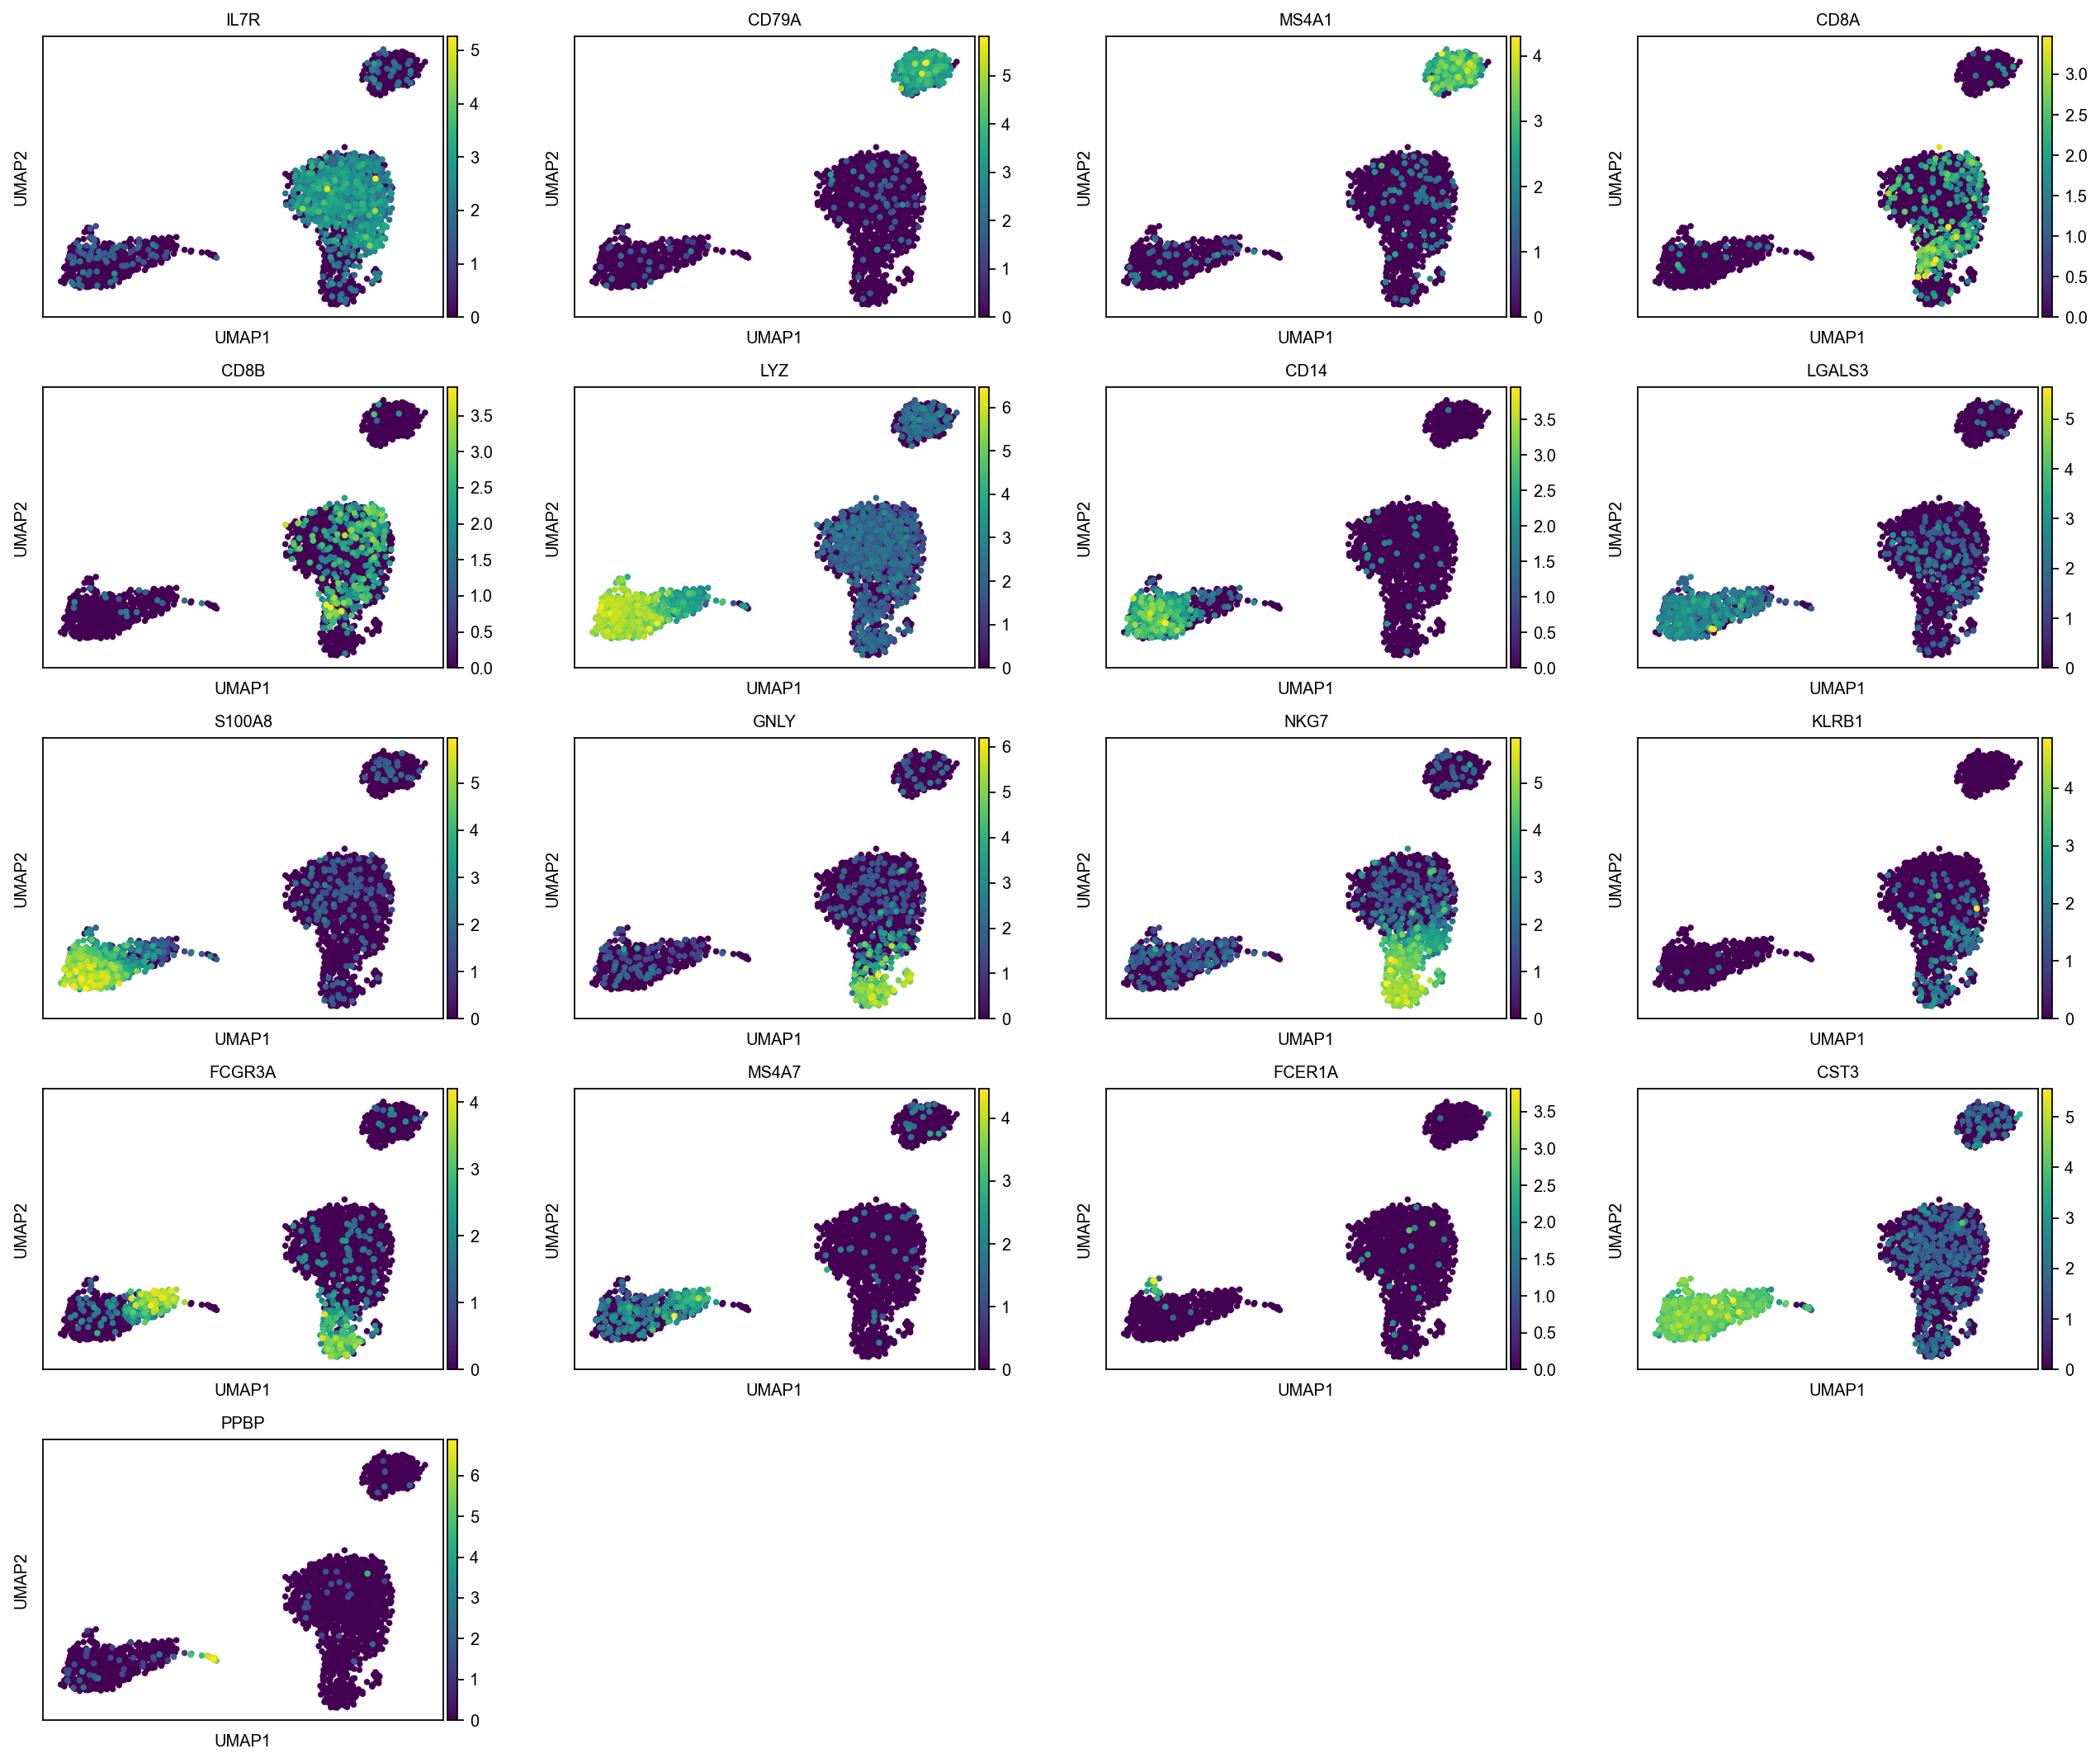

In [45]:
sc.pl.umap(adata, color=[i for i in marker_genes], color_map='viridis', legend_fontsize=8, save='_PBMC_markers')

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [46]:
adata = sc.read(results_file)

Get a table with the scores and groups.

In [47]:
result = adata.uns['rank_genes_groups']

In [48]:
groups = result['names'].dtype.names
pd.DataFrame(
    {
        group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals']
    }
).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  8.621941e-207     LYZ  2.932958e-259      CD74  1.093074e-185  CCL5   
1   LDHB  1.335858e-205  S100A9  2.188155e-248   HLA-DRA  4.601508e-170  NKG7   
2  RPS25  6.765878e-186  S100A8  5.078483e-239     CD79A  5.895558e-167   B2M   
3  RPS27  1.814325e-173    CST3  5.363760e-229     CD79B  3.059363e-153  IL32   
4   RPS6  4.943567e-170  TYROBP  7.857935e-227  HLA-DPB1  4.113830e-151  CST7   

             3_p   4_n           4_p     5_n           5_p    6_n  \
0  2.862569e-119  NKG7  5.373472e-93    LST1  1.543986e-79    PF4   
1   2.845806e-96  GNLY  2.538691e-86  FCER1G  7.701883e-76   PPBP   
2   2.054445e-79  GZMB  3.396437e-85    AIF1  1.487030e-74   SDPR   
3   9.805925e-77  CTSW  3.117011e-84   COTL1  2.313856e-72  GNG11   
4   6.938473e-66  PRF1  3.635891e-83  FCGR3A  9.065744e-70   GPX1   

            6_p  
0  2.166091e-09  
1  2.171278e-09  
2  2.176477e-09  
3  2.176477e-09  
4  2.202656e-09

Compare to a single cluster: 

ranking genes
    finished (0:00:01)


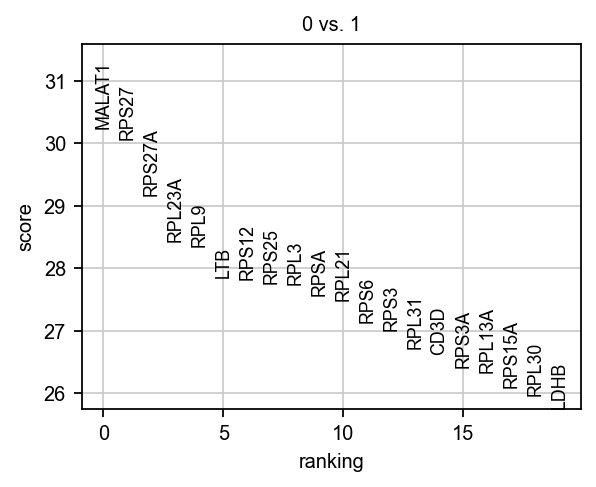

In [49]:
adata.uns['log1p']["base"] = None
# see the issue in scanpy==1.9.1 https://github.com/scverse/scanpy/pull/2283

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)


If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


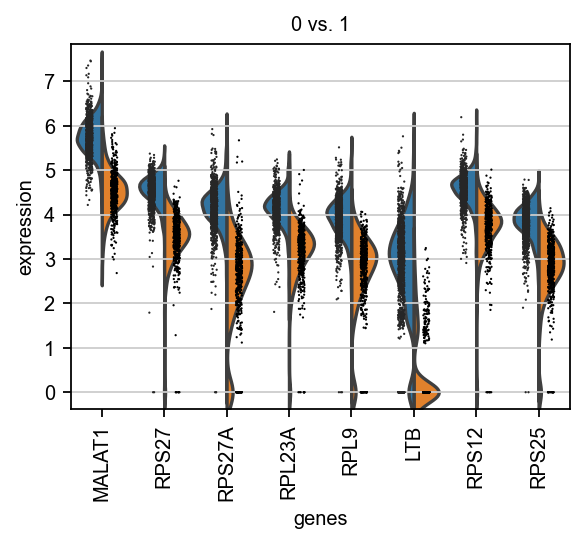

In [53]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [54]:
adata = sc.read(results_file)

c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


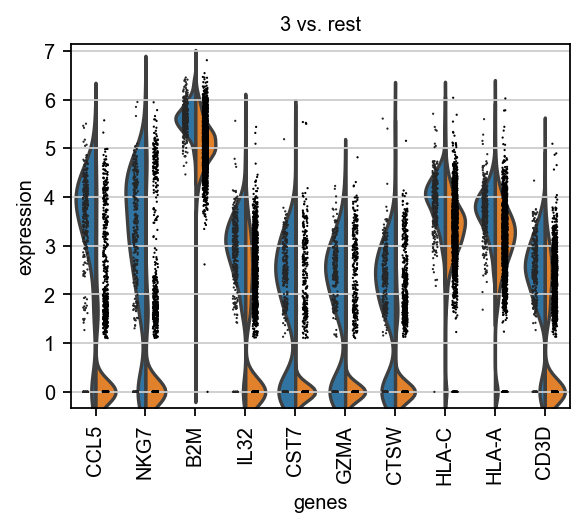

In [56]:
sc.pl.rank_genes_groups_violin(adata, groups='3', n_genes=10)

If you want to compare a certain gene across groups, use the following.

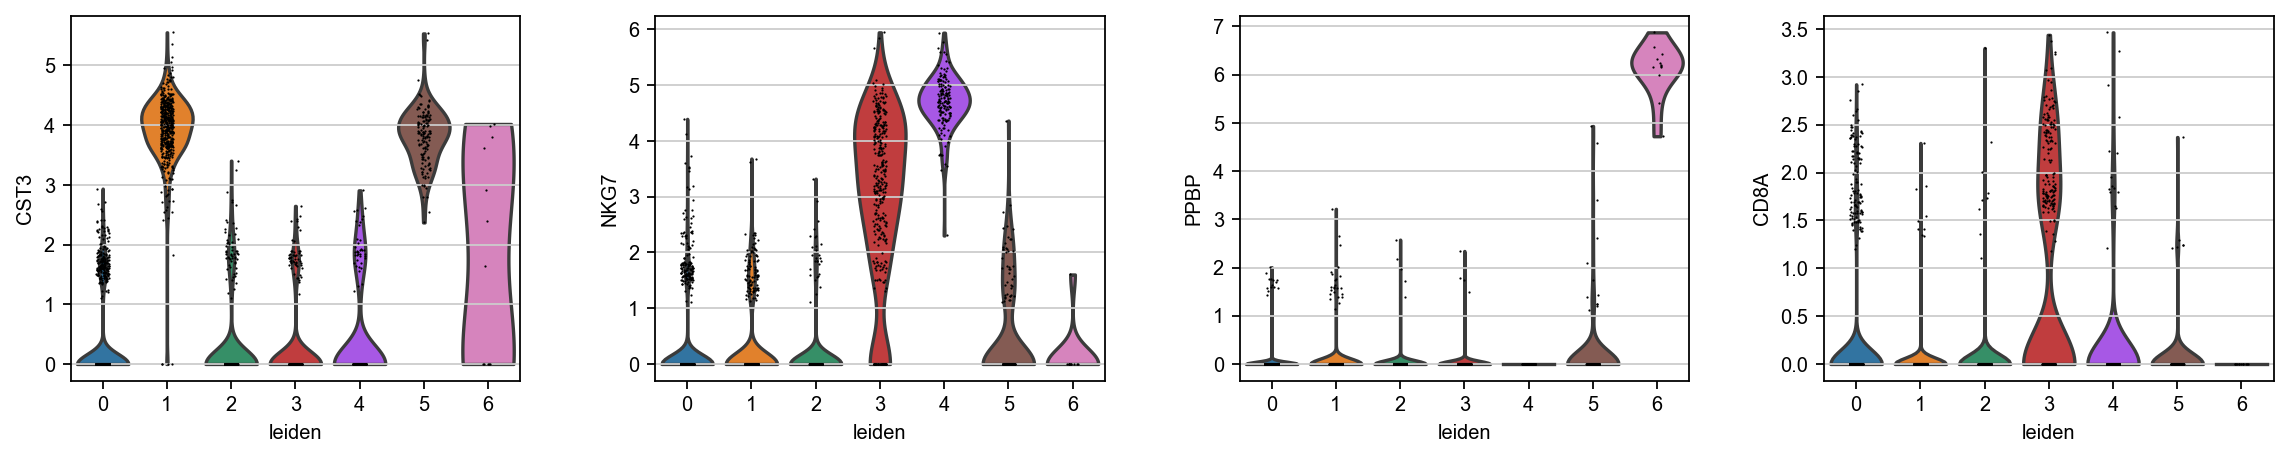

In [57]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP', 'CD8A'], groupby='leiden')

Next, lets generate a UMAP plot with the clusters explicitly labeled so it's a easier to see which cluster corresponds with our PBMC markers.

If too many clusters for a same population of cells, we could use a dictionary for mapping, where each cell type is assigned multiple clusters so they can be merged:

```python
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = {
    'CD4 T': ['3','4','6','9','10','12'],
    'CD14+ Mono': ['8'],
    'B': ['1','7','11'],
    'CD8 T': ['2'],
    'FCGR3A+ Mono': ['5'],
    'NK': ['0','14','17','18'],
    'DC': ['13','16'],
    'IGHA+': ['15'],
    'ZNF385D+': ['19']
}

# Initialize empty column in cell metadata
adata.obs['merged'] = np.nan

# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'merged'] = i
```

See also the mapping the other way:

```python
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Monocytes',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'B-cell',
     '5': 'Dendritic',
     '6': 'Plasma',
     '7': 'Other',
     '8': 'Dendritic',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')
```

In [58]:
# Actually mark the cell types.
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 'NK',
    'FCGR3A Monocytes',
    'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\anndata\_core\anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


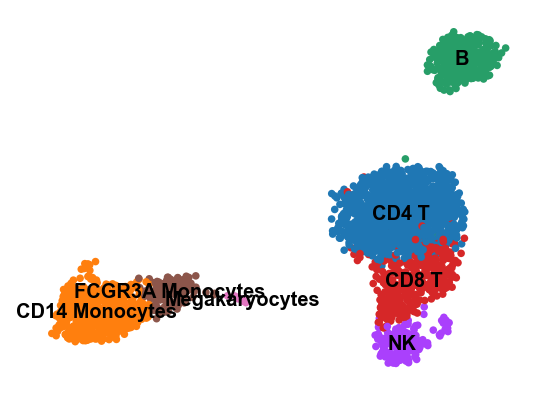

In [59]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

c:\Users\Sébastien\Documents\data_science\bioinformatics\sanbomics_scripts\.scanpy_env\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


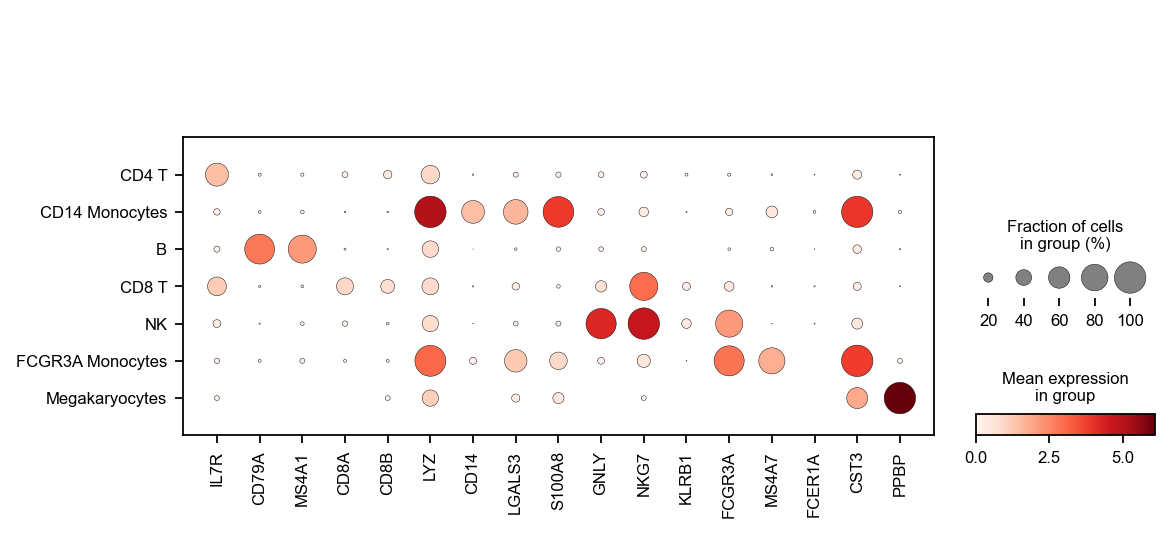

In [60]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

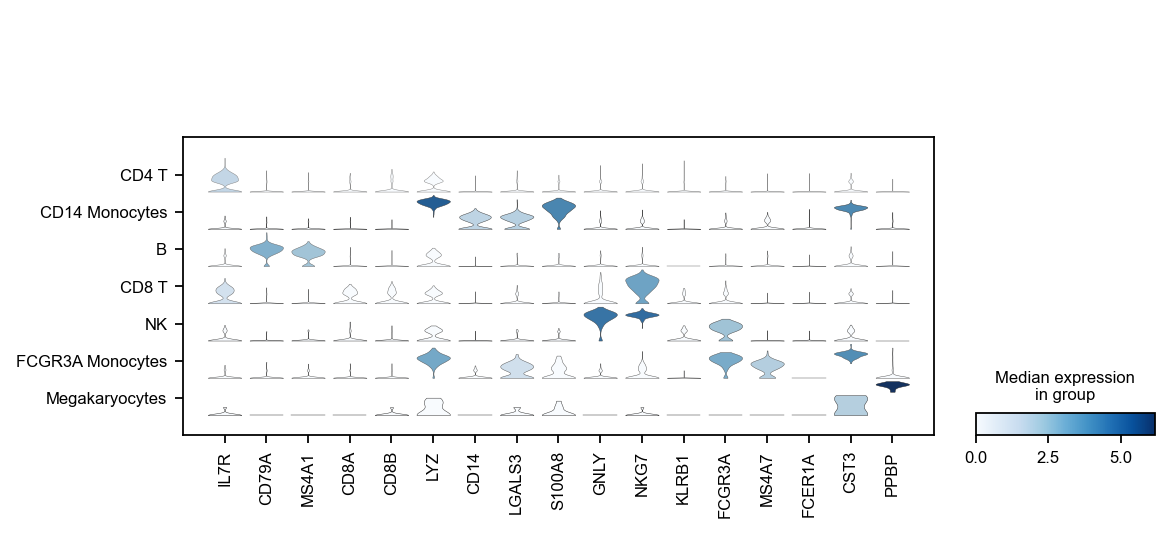

In [61]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [62]:
adata

AnnData object with n_obs × n_vars = 2574 × 1809
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [63]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [64]:
adata.raw.to_adata().write('./data/write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )